# Settings

In [1]:
args = {}
### action
args['load_config'] = '' # help='Path to config.json file to load args from.'
args['train'] = True   # help='Train model.'
args['evaluate_single_model'] = False # help='Evaluate a single model.'
args['evaluate_ensemble'] = False # help='Evaluate an ensemble (given a checkpoints tracker of saved model checkpoints)
args['visualize'] = False # help='Visualize Grad-CAM.'
args['plot_roc'] = True # help='Filename for metrics json file to plot ROC.'
# args['seed'] = 0          # help='Random seed to use.'
args['cuda'] = '1,2'
args['device'] = 'cuda'

### model architecture
args['model'] = 'mobilenet_v2' # help='What model architecture to use. (densenet121, resnet152, mobilenet_v2, efficientnet-b[0-7])')


### paths
# 'Location of train/valid datasets directory or path to test csv file.')
args['data_path'] = 'Path to ChestXpert dataset location'
# help='Path to experiment output, config, checkpoints, etc.')
args['output_dir'] = 'Path to save your trained model'
# type=str, help='Path to a single model checkpoint to restore or folder of checkpoints to ensemble.')
args['restore'] = ''



### data params
args['mini_data'] = None # type=int, help='Truncate dataset to this number of examples.')
args['resize'] = (512, 512) # type=int, help='Size of minimum edge to which to resize images.')


### training params
args['drop_lateral'] = True # help='drop all lateral direction images'
args['pretrained'] = False # help='Use ImageNet pretrained model and normalize data mean and std.')
args['batch_size'] = 64    # default=16, help='Dataloaders batch size.')
args['n_epochs'] = 20       # help='Number of epochs to train.')
args['lr'] = 1e-4     # default=1e-4, help='Learning rate.')
args['lr_warmup_steps'] = 5000        # help='Linear warmup of the learning rate for lr_warmup_steps number of steps.')
args['lr_decay_factor'] = 0.97        # help='Decay factor if exponential learning rate decay scheduler.')
args['step'] = 0           # help='Current step of training (number of minibatches processed).')
args['log_interval'] = 50        # help='Interval of num batches to show loss statistics.')
args['eval_interval'] = 300       # help='Interval of num epochs to evaluate, checkpoint, and save samples.')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import random
import matplotlib
# matplotlib.use('Agg')
%matplotlib inline
import imgaug.augmenters as iaa
import imgaug as ia
from PIL import Image
from PIL import ImageFile


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from tqdm import tqdm
# from tensorboardX import SummaryWriter

import os
import pprint
# import argparse
import time
import json
from functools import partial
from tensorboardX import SummaryWriter

# dataset and models
from dataset import ChexpertSmall, extract_patient_ids
from torchvision.models import resnet152, densenet121, mobilenet_v2# efficientnet_b2#, efficientnet_b3 #### vgg, res, dense
from torchvision.utils import make_grid
import torchvision
print(torchvision.version)

# from models.efficientnet import construct_model #### efficient
# from models.attn_aug_conv import DenseNet, ResNet, Bottleneck

os.environ["CUDA_VISIBLE_DEVICES"] = args['cuda']

### random seed
cudnn.benchmark = True
args['manual_seed'] = 41
random.seed(args['manual_seed'])
np.random.seed(args['manual_seed'])
torch.manual_seed(args['manual_seed'])
torch.cuda.manual_seed(args['manual_seed'])

if os.path.exists(args['output_dir']) is False:
    os.mkdir(args['output_dir'])
args['output_dir'] += args['model']
if os.path.exists(args['output_dir']) is False:
    os.mkdir(args['output_dir'])

# Utils

## Data IO

In [6]:
'''data augmentation'''
from PIL import Image
#from matplotlib import cm
class Augmenter(object):
    def __init__(self):
        self.aug_seq = iaa.Sequential([
            iaa.AdditiveGaussianNoise(scale=(0.0*255, 0.02*255), per_channel=True),
#             iaa.GaussianBlur(sigma=(0.0, 1.0))
        ])
    
    def __call__(self, img):
        img = np.asarray(img)
        aug_img = self.aug_seq(image=img)
        aug_img = Image.fromarray(aug_img)
        return aug_img
    
AUGMENT = Augmenter()

In [7]:
def fetch_dataloader(args, mode):
    assert mode in ['train', 'valid', 'test', 'vis']
    if mode == 'train':
        transforms = T.Compose([
            T.Resize(args['resize']),
            T.Lambda(AUGMENT),
            T.CenterCrop(args['resize']),
            T.RandomHorizontalFlip(),
            T.ToTensor(), #lambda x: torch.from_numpy(np.array(x, copy=True)).float().div(255).unsqueeze(0), # tensor in [0,1]
#             T.Normalize(mean=[0.5330], std=[0.0349]), # whiten with dataset mean and std
#             lambda x: x.expand(3,-1,-1)# expand to 3 channels
        ])
    if mode == 'valid' or mode == 'vis' or mode == 'test':
        transforms = T.Compose([
            T.Resize(args['resize']),
            T.ToTensor(), #lambda x: torch.from_numpy(np.array(x, copy=True)).float().div(255).unsqueeze(0), # tensor in [0,1]
#             T.Normalize(mean=[0.5330], std=[0.0349]), # whiten with dataset mean and std
        ])

    dataset = ChexpertSmall(args['data_path'], mode, transforms, mini_data=args['mini_data'], drop_lateral=args['drop_lateral'])

    return DataLoader(dataset, args['batch_size'], shuffle=(mode=='train'), pin_memory=(args['device']=='cuda'),
                       num_workers=0 if mode=='valid' else 16)  # since evaluating the valid_dataloader is called inside the
                                                              # train_dataloader loop, 0 workers for valid_dataloader avoids
                                                              # forking (cf torch dataloader docs); else memory sharing gets clunky

In [8]:
### save and reload json files
def save_json(data, filename, args):
    with open(os.path.join(args['output_dir'], filename + '.json'), 'w') as f:
        json.dump(data, f, indent=4)

def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def save_checkpoint(checkpoint, optim_checkpoint, sched_checkpoint, args, max_records=10):
    """ save model and optimizer checkpoint along with csv tracker
    of last `max_records` best number of checkpoints as sorted by avg auc """
    # 1. save latest
    torch.save(checkpoint, os.path.join(args['output_dir'], 'checkpoint_latest.pt'))
    torch.save(optim_checkpoint, os.path.join(args['output_dir'], 'optim_checkpoint_latest.pt'))
    if sched_checkpoint: torch.save(sched_checkpoint, os.path.join(args['output_dir'], 'sched_checkpoint_latest.pt'))

    # 2. save the last `max_records` number of checkpoints as sorted by avg auc
    tracker_path = os.path.join(args['output_dir'], 'checkpoints_tracker.csv')
    tracker_header = ' '.join(['CheckpointId', 'Step', 'Loss', 'AvgAUC'])

    # 2a. load checkpoint stats from file
    old_data = None             # init and overwrite from records
    file_id = 0                 # init and overwrite from records
    lowest_auc = float('-inf')  # init and overwrite from records
    if os.path.exists(tracker_path):
        old_data = np.atleast_2d(np.loadtxt(tracker_path, skiprows=1))
        file_id = len(old_data)
        if len(old_data) == max_records: # remove the lowest-roc record and add new checkpoint record under its file-id
            lowest_auc_idx = old_data[:,3].argmin()
            lowest_auc = old_data[lowest_auc_idx, 3]
            file_id = int(old_data[lowest_auc_idx, 0])
            old_data = np.delete(old_data, lowest_auc_idx, 0)

    # 2b. update tracking data and sort by descending avg auc
    data = np.atleast_2d([file_id, args['step'], checkpoint['eval_loss'], checkpoint['avg_auc']])
    if old_data is not None: data = np.vstack([old_data, data])
    data = data[data.argsort(0)[:,3][::-1]]  # sort descending by AvgAUC column

    # 2c. save tracker and checkpoint if better than what is already saved
    if checkpoint['avg_auc'] > lowest_auc:
        np.savetxt(tracker_path, data, delimiter=' ', header=tracker_header)
        torch.save(checkpoint, os.path.join(args['output_dir'], 'best_checkpoints', 'checkpoint_{}.pt'.format(file_id)))

## Evaluation metrics

In [9]:
def compute_metrics(outputs, targets, losses):
    n_classes = outputs.shape[1]
    fpr, tpr, aucs, precision, recall = {}, {}, {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(targets[:,i], outputs[:,i])
        aucs[i] = auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = precision_recall_curve(targets[:,i], outputs[:,i])
        fpr[i], tpr[i], precision[i], recall[i] = fpr[i].tolist(), tpr[i].tolist(), precision[i].tolist(), recall[i].tolist()

    metrics = {'fpr': fpr,
               'tpr': tpr,
               'aucs': aucs,
               'precision': precision,
               'recall': recall,
               'loss': dict(enumerate(losses.mean(0).tolist()))}
    return metrics

## Train and evaluate

In [10]:
def train_epoch(model, train_dataloader, valid_dataloader, loss_fn, optimizer, scheduler, writer, epoch, args):
    model.train()
    with tqdm(total=len(train_dataloader), desc='Step at start {}; Training epoch {}/{}'
              .format(args['step'], epoch+1, args['n_epochs'])) as pbar:
        for x, target, idxs in train_dataloader:
            args['step'] += 1
            out = model(x.cuda())
            loss = loss_fn(out, target.cuda()).sum(1).mean(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if scheduler and args['step'] >= args['lr_warmup_steps']: scheduler.step()
            pbar.set_postfix(loss = '{:.4f}'.format(loss.item()))
            pbar.update()
            # record
            if args['step'] % args['log_interval'] == 0:
                writer.add_scalar('train_loss', loss.item(), args['step'])
                writer.add_scalar('lr', optimizer.param_groups[0]['lr'], args['step'])
            # evaluate and save on eval_interval
            if args['step'] % args['eval_interval'] == 0:
                with torch.no_grad():
                    model.eval()
                    eval_metrics = evaluate_single_model(model, valid_dataloader, loss_fn, args)
                    writer.add_scalar('eval_loss', np.sum(list(eval_metrics['loss'].values())), args['step'])
                    for k, v in eval_metrics['aucs'].items():
                        writer.add_scalar('eval_auc_class_{}'.format(k), v, args['step'])
                    # save model
                    save_checkpoint(checkpoint={'global_step': args['step'],
                                                'eval_loss': np.sum(list(eval_metrics['loss'].values())),
                                                'avg_auc': np.nanmean(list(eval_metrics['aucs'].values())),
                                                'state_dict': model.state_dict()},
                                    optim_checkpoint=optimizer.state_dict(),
                                    sched_checkpoint=scheduler.state_dict() if scheduler else None,
                                    args=args)
                    # switch back to train mode
                    model.train()

In [11]:
@torch.no_grad()
def evaluate(model, dataloader, loss_fn, args):
    model.eval()
    targets, outputs, losses = [], [], []
    for x, target, idxs in dataloader:
        out = model(x.cuda())
        loss = loss_fn(out, target.cuda())
        outputs += [out.cpu()]
        targets += [target]
        losses  += [loss.cpu()]
    return torch.cat(outputs), torch.cat(targets), torch.cat(losses)

def evaluate_single_model(model, dataloader, loss_fn, args):
    outputs, targets, losses = evaluate(model, dataloader, loss_fn, args)
    return compute_metrics(outputs, targets, losses)

def evaluate_ensemble(model, dataloader, loss_fn, args):
    checkpoints = [c for c in os.listdir(args['restore']) \
                        if c.startswith('checkpoint') and c.endswith('.pt')]
    print('Running ensemble prediction using {} checkpoints.'.format(len(checkpoints)))
    outputs, losses = [], []
    for checkpoint in checkpoints:
        # load weights
#         model_checkpoint = torch.load(os.path.join(args['restore'], checkpoint), map_location=args.device)
        model_checkpoint = torch.load(os.path.join(args['restore'], checkpoint)).cuda()
        model.load_state_dict(model_checkpoint['state_dict'])
        del model_checkpoint
        # evaluate
        outputs_, targets, losses_ = evaluate(model, dataloader, loss_fn, args)
        outputs += [outputs_]
        losses  += [losses_]

    # take mean over checkpoints
    outputs  = torch.stack(outputs, dim=2).mean(2)
    losses = torch.stack(losses, dim=2).mean(2)
    return compute_metrics(outputs, targets, losses)

In [12]:
def train_and_evaluate(model, train_dataloader, valid_dataloader, loss_fn, optimizer, scheduler, writer, args):
    for epoch in range(args['n_epochs']):
        # train
        train_epoch(model, train_dataloader, valid_dataloader, loss_fn, optimizer, scheduler, writer, epoch, args)

        # evaluate
        print('Evaluating...', end='\r')
        eval_metrics = evaluate_single_model(model, valid_dataloader, loss_fn, args)
        print('Evaluate metrics @ step {}:'.format(args['step']))
        print('AUC:\n', pprint.pformat(eval_metrics['aucs']))
        print('Loss:\n', pprint.pformat(eval_metrics['loss']))
        writer.add_scalar('eval_loss', np.sum(list(eval_metrics['loss'].values())), args['step'])
        for k, v in eval_metrics['aucs'].items():
            writer.add_scalar('eval_auc_class_{}'.format(k), v, args['step'])

        # save eval metrics
        save_json(eval_metrics, 'eval_results_step_{}'.format(args['step']), args)

## Visualization

In [13]:
@torch.enable_grad()
def grad_cam(model, x, hooks, cls_idx=None):
    """ cf CheXpert: Test Results / Visualization; visualize final conv layer, using grads of final linear layer as weights,
    and performing a weighted sum of the final feature maps using those weights.
    cf Grad-CAM https://arxiv.org/pdf/1610.02391.pdf """
    model.eval()
    model.zero_grad()
    # register backward hooks
    conv_features, linear_grad = [], []
    forward_handle = hooks['forward'].register_forward_hook(lambda module, in_tensor, out_tensor: conv_features.append(out_tensor))
    backward_handle = hooks['backward'].register_backward_hook(lambda module, grad_input, grad_output: linear_grad.append(grad_input))

    # run model forward and create a one hot output for the given cls_idx or max class
    outputs = model(x)
    if not cls_idx: cls_idx = outputs.argmax(1)
    one_hot = F.one_hot(cls_idx, outputs.shape[1]).float().requires_grad_(True)

    # run model backward
    one_hot.mul(outputs).sum().backward()

    # compute weights; cf. Grad-CAM eq 1 -- gradients flowing back are global-avg-pooled to obtain the neuron importance weights
    weights = linear_grad[0][2].mean(1).view(1, -1, 1, 1)
    # compute weighted combination of forward activation maps; cf Grad-CAM eq 2; linear combination over channels
    cam = F.relu(torch.sum(weights * conv_features[0], dim=1, keepdim=True))

    # normalize each image in the minibatch to [0,1] and upscale to input image size
    cam = cam.clone()  # avoid modifying tensor in-place
    def norm_ip(t, min, max):
        t.clamp_(min=min, max=max)
        t.add_(-min).div_(max - min + 1e-5)

    for t in cam:  # loop over mini-batch dim
        norm_ip(t, float(t.min()), float(t.max()))
    cam = F.interpolate(cam, x.shape[2:], mode='bilinear', align_corners=True)

    # cleanup
    forward_handle.remove()
    backward_handle.remove()
    model.zero_grad()

    return cam

In [14]:
def visualize(model, dataloader, grad_cam_hooks, args):
    attr_names = dataloader.dataset.attr_names

    # 1. run through model to compute logits and grad-cam
    imgs, labels, scores, masks, idxs = [], [], [], [], []
    for x, target, idx in dataloader:
        imgs += [x]
        labels += [target]
        idxs += idx.tolist()
        x = x.cuda()
        scores += [model(x).cpu()]
        masks  += [grad_cam(model, x, grad_cam_hooks).cpu()]
    imgs, labels, scores, masks = torch.cat(imgs), torch.cat(labels), torch.cat(scores), torch.cat(masks)

    # 2. renormalize images and convert everything to numpy for matplotlib
    imgs.mul_(0.0349).add_(0.5330)
    imgs = imgs.permute(0,2,3,1).data.numpy()
    labels = labels.data.numpy()
    patient_ids = extract_patient_ids(dataloader.dataset, idxs)
    masks = masks.permute(0,2,3,1).data.numpy()
    probs = scores.sigmoid().data.numpy()

    # 3. make column grid of [model probs table, original image, grad-cam image] for each attr + other categories
    for attr, vis_idxs in zip(dataloader.dataset.vis_attrs, dataloader.dataset.vis_idxs):
        fig, axs = plt.subplots(3, 3, figsize=(4 * imgs.shape[1]/100, 3.3 * imgs.shape[2]/100), dpi=100, frameon=False)
        fig.suptitle(attr)
        for i, idx in enumerate(vis_idxs):
            offset = idxs.index(idx)
            visualize_one(model, imgs[offset], masks[offset], labels[offset], patient_ids[offset], probs[offset], attr_names, axs[i])

        filename = 'vis_{}_step_{}.png'.format(attr.replace(' ', '_'), args['step'])
        plt.savefig(os.path.join(args['output_dir'], 'vis', filename), dpi=100)
        plt.close()

In [15]:
def visualize_one(model, img, mask, label, patient_id, prob, attr_names, axs):
    """ display [table of model vs ground truth probs | original image | grad-cam mask image] in a given suplot axs """
    # sort data by prob high to low
    sort_idxs = prob.argsort()[::-1]
    label = label[sort_idxs]
    prob = prob[sort_idxs]
    names = [attr_names[i] for i in sort_idxs]
    # 1. left -- show table of ground truth and predictions, sorted by pred prob high to low
    axs[0].set_title(patient_id)
    data = np.stack([label, prob.round(3)]).T
    axs[0].table(cellText=data, rowLabels=names, colLabels=['Ground truth', 'Pred. prob'],
                 rowColours=plt.cm.Greens(0.5*label),
                 cellColours=plt.cm.Greens(0.5*data), cellLoc='center', loc='center')
    axs[0].axis('tight')
    # 2. middle -- show original image
    axs[1].set_title('Original image', fontsize=10)
    axs[1].imshow(img.squeeze(), cmap='gray')
    # 3. right -- show heatmap over original image with predictions
    axs[2].set_title('Top class activation \n{}: {:.4f}'.format(names[0], prob[0]), fontsize=10)
    axs[2].imshow(img.squeeze(), cmap='gray')
    axs[2].imshow(mask.squeeze(), cmap='jet', alpha=0.5)

    for ax in axs: ax.axis('off')

In [16]:
def vis_attn(x, patient_ids, idxs, attn_layers, args, batch_element=0):
    H, W = x.shape[2:]
    nh = attn_layers[0].nh

    # select which pixels to visualize -- e.g. select virtices of a center square of side 1/3 of the image dims
    pix_to_vis = lambda h, w: [(h//3, w//3), (h//3, int(2*w/3)), (int(2*h/3), w//3), (int(2*h/3), int(2*w/3))]
    window = 30  # take mean attn around the pix_to_vis in a window of size ws

    for j, l in enumerate(attn_layers):
        # visualize attention maps (rows for each head; columns for each pixel)
        fig, axs = plt.subplots(nh+1, 4, figsize=(3,3/4*(1+nh)), frameon=False)
        fig.suptitle(patient_ids[batch_element], fontsize=8)
        # display target image; highlight pixel
        for ax, (ph, pw) in zip(axs[0], pix_to_vis(H,W)):
            image = x.clone().detach().mul_(0.0349).add_(0.5330)  # renormalize
            # add yellow pixel on the pix_to_vis for visualization
            image[:,:,ph-window:ph+window,pw-window:pw+window] = torch.tensor([1., 215/255, 0]).view(1,3,1,1) 
            ax.imshow(image[batch_element].permute(1,2,0).numpy())
            ax.axis('off')
        # display attention maps
        # get attention weights tensor for the batch element
        attn = l.weights.data[batch_element]
        # reshape attn tensor and select the pixels to visualize
        h = w = int(np.sqrt(attn.shape[-1]))
        ws = max(1, int(window * h/H))  # scale window to feature map size
        attn = attn.reshape(nh, h, w, h, w)
        for i, (ph, pw) in enumerate(pix_to_vis(h,w)):
            for h in range(nh):
                axs[h+1, i].imshow(attn[h, ph-ws:ph+ws, pw-ws:pw+ws, :, :].mean([0,1]).cpu().numpy())
                axs[h+1, i].axis('off')


        filename = 'attn_image_idx_{}_{}_layer_{}.png'.format(idxs[batch_element], batch_element, j)
        fig.subplots_adjust(0,0,1,0.95,0.05,0.05)
        plt.savefig(os.path.join(args['output_dir'], 'vis', filename))
        plt.close()

In [17]:
def plot_roc(metrics, args, filename, labels=ChexpertSmall.attr_names):
    fig, axs = plt.subplots(2, len(labels), figsize=(24,12))

    for i, (fpr, tpr, aucs, precision, recall, label) in enumerate(zip(metrics['fpr'].values(), metrics['tpr'].values(),
                                                                       metrics['aucs'].values(), metrics['precision'].values(),
                                                                       metrics['recall'].values(), labels)):
        # top row -- ROC
        axs[0,i].plot(fpr, tpr, label='AUC = %0.2f' % aucs)
        axs[0,i].plot([0, 1], [0, 1], 'k--')  # diagonal margin
        axs[0,i].set_xlabel('False Positive Rate')
        # bottom row - Precision-Recall
        axs[1,i].step(recall, precision, where='post')
        axs[1,i].set_xlabel('Recall')
        # format
        axs[0,i].set_title(label)
        axs[0,i].legend(loc="lower right")

    plt.suptitle(filename)
    axs[0,0].set_ylabel('True Positive Rate')
    axs[1,0].set_ylabel('Precision')

    for ax in axs.flatten():
        ax.set_xlim([0.0, 1.05])
        ax.set_ylim([0.0, 1.05])
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.savefig(os.path.join(args['output_dir'], 'plots', filename + '.png'), pad_inches=0.)
    plt.close()

# Main

## dataloader

In [18]:
# import pandas as pd
# csv_path = '/home/Attack_Attn/ChestXpert/CheXpert-v1.0-small/train.csv'
# attr_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
#                       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
#                       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
#                       'Fracture', 'Support Devices']
# train_df = pd.read_csv(csv_path, keep_default_na=True)
# # 1. fill NAs (blanks for unmentioned) as 0 (negatives)
# # attr columns ['No Finding', ..., 'Support Devices']; note AP/PA remains with NAs for Lateral pictures
# train_df[attr_names] = train_df[attr_names].fillna(0)
# # 2. fill -1 as 1 (U-Ones method described in paper)  # TODO -- setup options for uncertain labels
# train_df[attr_names] = train_df[attr_names].replace(-1,1)

# df_clear = train_df.drop(train_df[train_df['Frontal/Lateral']!='Frontal'].index)
# df_clear

In [19]:
args['train'] = True   # help='Train model.'
# if args['seed']:
#     torch.manual_seed(args['seed'])
#     np.random.seed(args['seed'])

Train data length:  191027
Valid data length:  202
tensor([[1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1.]])
torch.Size([64, 1, 512, 512]) tensor(1.) tensor(0.)


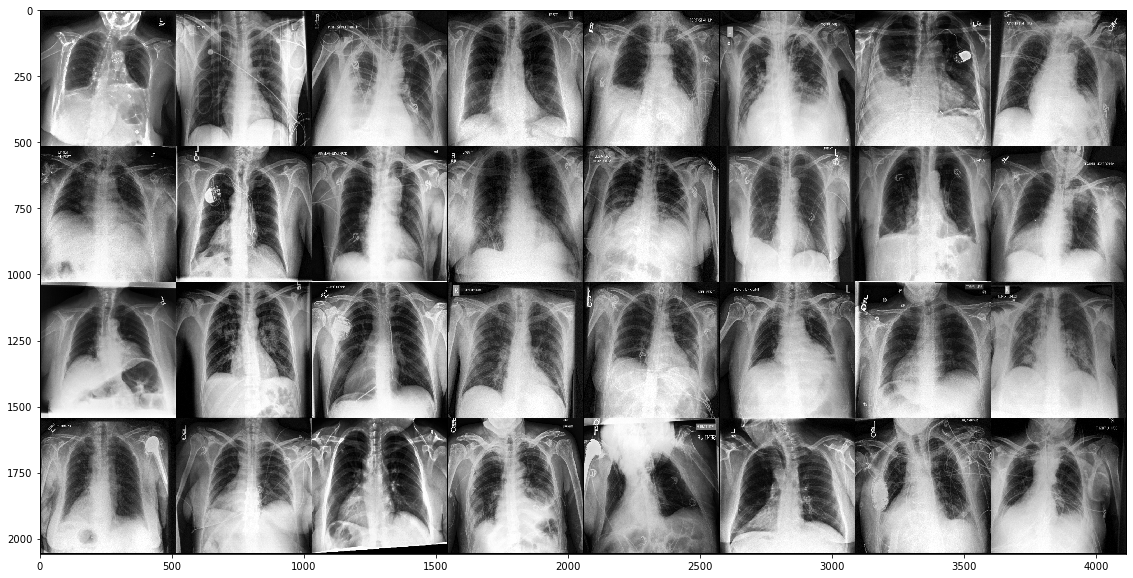

In [20]:
train_dataloader = fetch_dataloader(args, mode='train')
valid_dataloader = fetch_dataloader(args, mode='valid')
    
print('Train data length: ', len(train_dataloader.dataset))
print('Valid data length: ', len(valid_dataloader.dataset))

batch_datas, batch_labels, batch_index = next(iter(train_dataloader)) 
print(batch_labels[0:5])

# print images
plt.figure(figsize=(20,10))
img = make_grid(batch_datas[0:32], nrow=8, padding=2)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# batch size
print(batch_datas.size(), batch_datas.max(), batch_datas.min())

tensor([[0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.]])
torch.Size([64, 1, 512, 512]) tensor(1.) tensor(0.)


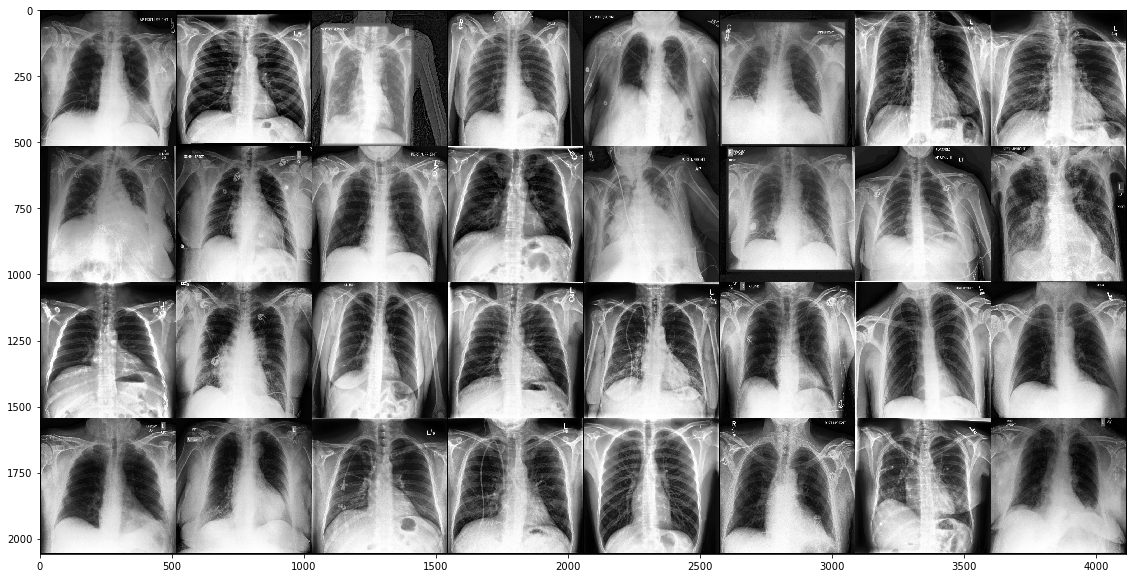

In [21]:
batch_datas, batch_labels, batch_index = next(iter(valid_dataloader)) 
print(batch_labels[0:5])

# print images
plt.figure(figsize=(20,10))
img = make_grid(batch_datas[0:32], nrow=8, padding=2)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# batch size
print(batch_datas.size(), batch_datas.max(), batch_datas.min())

## model

In [22]:
'''output dir'''
if not args['output_dir']:
    if args['restore']: raise RuntimeError('Must specify `output_dir` argument')
    args['output_dir']: args['output_dir'] = os.path.join('results', time.strftime('%Y-%m-%d_%H-%M-%S', time.gmtime()))
# make new folders if they don't exist
writer = SummaryWriter(logdir=args['output_dir'])  # creates output_dir
if not os.path.exists(os.path.join(args['output_dir'], 'vis')): os.makedirs(os.path.join(args['output_dir'], 'vis'))
if not os.path.exists(os.path.join(args['output_dir'], 'plots')): os.makedirs(os.path.join(args['output_dir'], 'plots'))
if not os.path.exists(os.path.join(args['output_dir'],'best_checkpoints')): os.makedirs(os.path.join(args['output_dir'],'best_checkpoints'))


In [23]:
'''model + optimer initialization'''
n_classes = len(ChexpertSmall.attr_names) ### Get class number
print('n_classes:{}'.format(n_classes))
if args['model']=='densenet121':
    model = densenet121(pretrained=args['pretrained']).cuda()
    ### 3-channel --> 1-channel
    old_module = model.features.conv0
    model.features.conv0 = nn.Conv2d(in_channels=1, out_channels=old_module.out_channels, 
                                     kernel_size=old_module.kernel_size, stride=old_module.stride, 
                                     padding=old_module.padding, dilation=old_module.dilation, 
                                     bias=old_module.bias).cuda()
    ### IN output (1000) --> CX output (14)
    model.classifier = nn.Linear(model.classifier.in_features, out_features=n_classes).cuda()
    nn.init.constant_(model.classifier.bias, 0) #####
    model = torch.nn.DataParallel(model).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
    scheduler = None
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args['n_epochs'])

elif args['model']=='mobilenet_v2':
    model = mobilenet_v2(pretrained=args['pretrained']).cuda()
    ### 3-channel --> 1-channel
    old_module = model.features[0][0]
    model.features[0][0] = nn.Conv2d(in_channels=1, out_channels=old_module.out_channels, 
                                    kernel_size=old_module.kernel_size, stride=old_module.stride, 
                                    padding=old_module.padding, dilation=old_module.dilation, 
                                    bias=old_module.bias).cuda()
    ### IN output (1000) --> CX output (14)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, out_features=n_classes).cuda()
    model = torch.nn.DataParallel(model).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
    scheduler = None
    
elif args['model']=='resnet152':
    model = resnet152(pretrained=args['pretrained']).cuda()
    ### 3-channel --> 1-channel
    old_module = model.conv1
    model.conv1 = nn.Conv2d(in_channels=1, out_channels=old_module.out_channels, 
                            kernel_size=old_module.kernel_size, stride=old_module.stride, 
                            padding=old_module.padding, dilation=old_module.dilation, 
                            bias=old_module.bias).cuda()
    ### IN output (1000) --> CX output (14)
    model.fc = nn.Linear(model.fc.in_features, out_features=n_classes).cuda()
    model = torch.nn.DataParallel(model).cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
    scheduler = None
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args['n_epochs'])

elif 'efficientnet' in args['model']:
    model = construct_model(args['model'], n_classes=n_classes).cuda()
    grad_cam_hooks = {'forward': model.head[1], 'backward': model.head[-1]}
    optimizer = torch.optim.RMSprop(model.parameters(), lr=args['lr'], momentum=0.9, eps=0.001)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, args['lr_decay_factor'])

else:
    raise RuntimeError('Model architecture not supported.')
    
print('Loaded {} (number of parameters: {:,}; weights trained to step {})'.format(
        model._get_name(), sum(p.numel() for p in model.parameters()), args['step']))

n_classes:5
Loaded DataParallel (number of parameters: 2,229,701; weights trained to step 0)


In [24]:
# model.features.conv0

In [25]:
'''load model if exists'''
if args['restore'] and os.path.isfile(args['restore']):  # restore from single file, else ensemble is handled by evaluate_ensemble
    print('Restoring model weights from {}'.format(args['restore']))
#         model_checkpoint = torch.load(args.restore, map_location=args.device)
    model_checkpoint = torch.load(args['restore']).cuda()
    model.load_state_dict(model_checkpoint['state_dict'])
    args['step'] = model_checkpoint['global_step']
    del model_checkpoint
    # if training, load optimizer and scheduler too
    if args['train']:
        print('Restoring optimizer.')
        optim_checkpoint_path = os.path.join(os.path.dirname(args['restore']), 'optim_' + os.path.basename(args['restore']))
#             optimizer.load_state_dict(torch.load(optim_checkpoint_path, map_location=args.device))
        optimizer.load_state_dict(torch.load(optim_checkpoint_path).cuda())
        if scheduler:
            print('Restoring scheduler.')
            sched_checkpoint_path = os.path.join(os.path.dirname(args['restore']), 'sched_' + os.path.basename(args['restore']))
            scheduler.load_state_dict(torch.load(sched_checkpoint_path).cuda())

# load data
if args['restore']:
    # load pretrained flag from config -- in case forgotten e.g. in post-training evaluation
    # (images still need to be normalized if training started on an imagenet pretrained model)
    args['pretrained'] = load_json(os.path.join(args['output_dir'], 'config.json'))['pretrained']

## loss

In [26]:
# setup loss function for train and eval
loss_fn = nn.BCEWithLogitsLoss(reduction='none').cuda()

## run

In [27]:
if args['train']:
    train_and_evaluate(model, train_dataloader, valid_dataloader, loss_fn, optimizer, scheduler, writer, args)
if args['evaluate_single_model']:
    eval_metrics = evaluate_single_model(model, valid_dataloader, loss_fn, args)
    print('Evaluate metrics -- \n\t restore: {} \n\t step: {}:'.format(args['restore'], args['step']))
    print('AUC:\n', pprint.pformat(eval_metrics['aucs']))
    print('Loss:\n', pprint.pformat(eval_metrics['loss']))
    save_json(eval_metrics, 'eval_results_step_{}'.format(args['step']), args)
if args['evaluate_ensemble']:
    assert os.path.isdir(args['restore']), 'Restore argument must be directory with saved checkpoints'
    eval_metrics = evaluate_ensemble(model, valid_dataloader, loss_fn, args)
    print('Evaluate ensemble metrics -- \n\t checkpoints path {}:'.format(args['restore']))
    print('AUC:\n', pprint.pformat(eval_metrics['aucs']))
    print('Loss:\n', pprint.pformat(eval_metrics['loss']))
    save_json(eval_metrics, 'eval_results_ensemble', args)
if args['visualize']:
    visualize(model, vis_dataloader, grad_cam_hooks, args)
    if attn_hooks is not None:
        for x, _, idxs in vis_dataloader:
            model(x.cuda())
            patient_ids = extract_patient_ids(vis_dataloader.dataset, idxs)
            # visualize stored attention weights for each image
            for i in range(len(x)): vis_attn(x, patient_ids, idxs, attn_hooks, args, i)
if args['plot_roc']:
    # load results files from output_dir
    filenames = [f for f in os.listdir(args['output_dir']) if f.startswith('eval_results') and f.endswith('.json')]
    if filenames==[]: raise RuntimeError('No `eval_results` files found in `{}` to plot results from.'.format(args['output_dir']))
    # load and plot each
    for f in filenames:
        plot_roc(load_json(os.path.join(args['output_dir'], f)), args, 'roc_pr_' + f.split('.')[0])
writer.close()

Step at start 0; Training epoch 1/20: 100%|██████████| 2985/2985 [08:25<00:00,  5.91it/s, loss=2.6058]


Step at start 2985; Training epoch 2/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 2985:
AUC:
 {0: 0.8093438320209974,
 1: 0.7641488413547237,
 2: 0.8799632352941177,
 3: 0.856547619047619,
 4: 0.8062726449275363}
Loss:
 {0: 0.5708023905754089,
 1: 0.6564760804176331,
 2: 0.36631205677986145,
 3: 0.3880841135978699,
 4: 0.5018483400344849}


Step at start 2985; Training epoch 2/20: 100%|██████████| 2985/2985 [08:14<00:00,  6.03it/s, loss=2.4484]


Step at start 5970; Training epoch 3/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 5970:
AUC:
 {0: 0.8173228346456692,
 1: 0.7725044563279857,
 2: 0.8757352941176471,
 3: 0.8800595238095238,
 4: 0.8747735507246377}
Loss:
 {0: 0.5445200800895691,
 1: 0.6366182565689087,
 2: 0.3566538393497467,
 3: 0.34774836897850037,
 4: 0.46040377020835876}


Step at start 5970; Training epoch 3/20: 100%|██████████| 2985/2985 [08:14<00:00,  6.04it/s, loss=2.1946]


Step at start 8955; Training epoch 4/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 8955:
AUC:
 {0: 0.8215223097112861,
 1: 0.8356729055258467,
 2: 0.8863970588235295,
 3: 0.8476190476190476,
 4: 0.8994565217391305}
Loss:
 {0: 0.5371270775794983,
 1: 0.6320385932922363,
 2: 0.3467394709587097,
 3: 0.3857975900173187,
 4: 0.38711392879486084}


Step at start 8955; Training epoch 4/20: 100%|██████████| 2985/2985 [08:17<00:00,  6.00it/s, loss=2.5920]


Step at start 11940; Training epoch 5/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 11940:
AUC:
 {0: 0.8115485564304463,
 1: 0.8490418894830659,
 2: 0.8720588235294118,
 3: 0.8979166666666667,
 4: 0.900475543478261}
Loss:
 {0: 0.5445904731750488,
 1: 0.6402739882469177,
 2: 0.34208816289901733,
 3: 0.34236133098602295,
 4: 0.36498796939849854}


Step at start 11940; Training epoch 5/20: 100%|██████████| 2985/2985 [08:15<00:00,  6.02it/s, loss=2.3365]


Step at start 14925; Training epoch 6/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 14925:
AUC:
 {0: 0.8223622047244095,
 1: 0.848596256684492,
 2: 0.888235294117647,
 3: 0.8982142857142857,
 4: 0.911911231884058}
Loss:
 {0: 0.524996817111969,
 1: 0.6547593474388123,
 2: 0.33718276023864746,
 3: 0.315512090921402,
 4: 0.3571810722351074}


Step at start 14925; Training epoch 6/20: 100%|██████████| 2985/2985 [08:16<00:00,  6.01it/s, loss=2.2648]


Step at start 17910; Training epoch 7/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 17910:
AUC:
 {0: 0.8356955380577428,
 1: 0.8341131907308378,
 2: 0.8777573529411764,
 3: 0.9029761904761905,
 4: 0.9086277173913043}
Loss:
 {0: 0.5520308017730713,
 1: 0.5930983424186707,
 2: 0.34224769473075867,
 3: 0.3271317780017853,
 4: 0.36120280623435974}


Step at start 17910; Training epoch 7/20: 100%|██████████| 2985/2985 [16:56<00:00,  2.94it/s, loss=2.3157]


Step at start 20895; Training epoch 8/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 20895:
AUC:
 {0: 0.8156430446194226,
 1: 0.8252005347593583,
 2: 0.8141544117647059,
 3: 0.8938988095238095,
 4: 0.9176856884057971}
Loss:
 {0: 0.5415545105934143,
 1: 0.6518563032150269,
 2: 0.36796408891677856,
 3: 0.4239254593849182,
 4: 0.35800662636756897}


Step at start 20895; Training epoch 8/20: 100%|██████████| 2985/2985 [19:12<00:00,  2.59it/s, loss=2.0889]


Step at start 23880; Training epoch 9/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 23880:
AUC:
 {0: 0.8055643044619423,
 1: 0.7925579322638145,
 2: 0.8737132352941176,
 3: 0.9046130952380952,
 4: 0.9113451086956523}
Loss:
 {0: 0.5377657413482666,
 1: 0.8162914514541626,
 2: 0.3399241864681244,
 3: 0.3125022053718567,
 4: 0.36764153838157654}


Step at start 23880; Training epoch 9/20: 100%|██████████| 2985/2985 [19:11<00:00,  2.59it/s, loss=2.6623]


Step at start 26865; Training epoch 10/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 26865:
AUC:
 {0: 0.7924409448818898,
 1: 0.8326648841354723,
 2: 0.835110294117647,
 3: 0.916517857142857,
 4: 0.9098731884057971}
Loss:
 {0: 0.5493556261062622,
 1: 0.703135073184967,
 2: 0.35783815383911133,
 3: 0.31350696086883545,
 4: 0.3627789616584778}


Step at start 26865; Training epoch 10/20: 100%|██████████| 2985/2985 [19:12<00:00,  2.59it/s, loss=2.0420]


Step at start 29850; Training epoch 11/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 29850:
AUC:
 {0: 0.824251968503937,
 1: 0.8416889483065954,
 2: 0.8799632352941176,
 3: 0.9229166666666666,
 4: 0.9170063405797102}
Loss:
 {0: 0.515913188457489,
 1: 0.5561675429344177,
 2: 0.32825514674186707,
 3: 0.2998228073120117,
 4: 0.3398483991622925}


Step at start 29850; Training epoch 11/20: 100%|██████████| 2985/2985 [19:13<00:00,  2.59it/s, loss=2.4432]


Step at start 32835; Training epoch 12/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 32835:
AUC:
 {0: 0.8431496062992125,
 1: 0.828542780748663,
 2: 0.8886029411764705,
 3: 0.9226190476190477,
 4: 0.9040987318840581}
Loss:
 {0: 0.5403637290000916,
 1: 0.6431534886360168,
 2: 0.3237302899360657,
 3: 0.29118508100509644,
 4: 0.35578930377960205}


Step at start 32835; Training epoch 12/20: 100%|██████████| 2985/2985 [19:11<00:00,  2.59it/s, loss=2.1290]


Step at start 35820; Training epoch 13/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 35820:
AUC:
 {0: 0.8331758530183727,
 1: 0.8262032085561498,
 2: 0.8994485294117647,
 3: 0.9163690476190476,
 4: 0.9188179347826086}
Loss:
 {0: 0.5247805118560791,
 1: 0.7293011546134949,
 2: 0.318861186504364,
 3: 0.29397332668304443,
 4: 0.3384121358394623}


Step at start 35820; Training epoch 13/20: 100%|██████████| 2985/2985 [18:55<00:00,  2.63it/s, loss=2.4325]


Step at start 38805; Training epoch 14/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 38805:
AUC:
 {0: 0.8251968503937008,
 1: 0.7921122994652406,
 2: 0.8354779411764706,
 3: 0.9186011904761905,
 4: 0.9111186594202898}
Loss:
 {0: 0.5280131697654724,
 1: 0.6732019782066345,
 2: 0.35660862922668457,
 3: 0.33117663860321045,
 4: 0.3610478639602661}


Step at start 38805; Training epoch 14/20: 100%|██████████| 2985/2985 [19:11<00:00,  2.59it/s, loss=2.1950]


Step at start 41790; Training epoch 15/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 41790:
AUC:
 {0: 0.7973753280839895,
 1: 0.8101604278074866,
 2: 0.8415441176470588,
 3: 0.921875,
 4: 0.9120244565217391}
Loss:
 {0: 0.5594644546508789,
 1: 0.6360894441604614,
 2: 0.35543668270111084,
 3: 0.2956240773200989,
 4: 0.34431448578834534}


Step at start 41790; Training epoch 15/20: 100%|██████████| 2985/2985 [19:11<00:00,  2.59it/s, loss=2.1717]


Step at start 44775; Training epoch 16/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 44775:
AUC:
 {0: 0.8240419947506561,
 1: 0.7701648841354725,
 2: 0.8295955882352941,
 3: 0.9101190476190476,
 4: 0.9145153985507246}
Loss:
 {0: 0.5336058139801025,
 1: 0.6960535049438477,
 2: 0.35596776008605957,
 3: 0.320835679769516,
 4: 0.3466285169124603}


Step at start 44775; Training epoch 16/20: 100%|██████████| 2985/2985 [19:11<00:00,  2.59it/s, loss=2.4677]


Step at start 47760; Training epoch 17/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 47760:
AUC:
 {0: 0.7921259842519686,
 1: 0.8009135472370766,
 2: 0.8009191176470588,
 3: 0.9032738095238094,
 4: 0.912703804347826}
Loss:
 {0: 0.5495726466178894,
 1: 0.7013252377510071,
 2: 0.3711734414100647,
 3: 0.33049699664115906,
 4: 0.35460907220840454}


Step at start 47760; Training epoch 17/20: 100%|██████████| 2985/2985 [19:09<00:00,  2.60it/s, loss=2.3952]


Step at start 50745; Training epoch 18/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 50745:
AUC:
 {0: 0.8188976377952756,
 1: 0.796902852049911,
 2: 0.8720588235294118,
 3: 0.9272321428571428,
 4: 0.9065896739130435}
Loss:
 {0: 0.5004692673683167,
 1: 0.7091708779335022,
 2: 0.3253035843372345,
 3: 0.26553890109062195,
 4: 0.3592516779899597}


Step at start 50745; Training epoch 18/20: 100%|██████████| 2985/2985 [19:08<00:00,  2.60it/s, loss=2.2753]


Step at start 53730; Training epoch 19/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 53730:
AUC:
 {0: 0.830761154855643,
 1: 0.8171791443850267,
 2: 0.8369485294117647,
 3: 0.9157738095238095,
 4: 0.9130434782608695}
Loss:
 {0: 0.5146003365516663,
 1: 0.6766156554222107,
 2: 0.3497335910797119,
 3: 0.30682820081710815,
 4: 0.38991275429725647}


Step at start 53730; Training epoch 19/20: 100%|██████████| 2985/2985 [19:06<00:00,  2.60it/s, loss=2.2214]


Step at start 56715; Training epoch 20/20:   0%|          | 0/2985 [00:00<?, ?it/s]

Evaluate metrics @ step 56715:
AUC:
 {0: 0.8006299212598424,
 1: 0.8123885918003564,
 2: 0.7941176470588236,
 3: 0.9113095238095238,
 4: 0.9146286231884059}
Loss:
 {0: 0.5435321927070618,
 1: 0.6654426455497742,
 2: 0.3718019127845764,
 3: 0.35635098814964294,
 4: 0.35694560408592224}


Step at start 56715; Training epoch 20/20: 100%|██████████| 2985/2985 [19:11<00:00,  2.59it/s, loss=2.1880]


Evaluate metrics @ step 59700:
AUC:
 {0: 0.8266666666666668,
 1: 0.7870989304812834,
 2: 0.8534926470588236,
 3: 0.9108630952380953,
 4: 0.9140625}
Loss:
 {0: 0.5236688852310181,
 1: 0.598328709602356,
 2: 0.342273473739624,
 3: 0.31496474146842957,
 4: 0.3504028022289276}
